# Introdução

O Modelo 1 consiste aplicar técnicas clássicas de ML para classificar a satisfação de clientes com a Base da Anatel, considerando o seguinte recote: 

- Dados de 2017 a 2020; 
- Remoção das Colunas E2, E4, E6 e E8, que representam respostas de satisfação condicionais; 
- Remoção das Colunas F2_1, F2_2, F2_3, F4_1, F4_2 e F4_3, que representam respostas condicionais em relação a serviços de manutenção e instalação; 
- Remoção das Colunas A2_1, A2_2, A2_3, A1_4, A3 e A4 que representam respostas condicionais a satisfação dos atendimentos telefonicos, via internet e presencial;
- Remoção das Colunas Q2, Q2_1, Q2_2 que representam a área de trabalho do entrevistado. 
- Remoção da Coluna Q3, que indica se o usuário é cliente da internet. No caso todas as linhas apresentam valores igual a 1. 
- Remoção da Q4 que pergunta de o respondentes é um dos principais usuários. No caso todas as linhas apresentam valores igual a 1. 
- Remoção da Coluna Q7a, que é respondida apenas caso o cliente se recusa a responder a idade.
- Remoção da Coluna IDTNS que é um indicador de pesquisa. 
- Remoção das Colunas G1, G2_1, G2_2, G2_3, que representam respostas condicionais em relação a concorrência do serviço na Região.
- Remoção da Coluna I1 que indica autorização para identificaçãod as respostas. 
- Remoção da Coluna COD_IBGE que indica uma codificação do IBGE.
- Remoção da Coluna PESO que indica um calculo UFxPrestadora;
- Remoção da Coluna Q1 que pergunta se o entrevistao tem interesse em participar da pesquisa. No caso todas as linhas tem mesmo valor. 
- Remoção da Coluna Q6 que indica se é PF ou PJ. No caso a base só abrange PF's;
- Remoção da Coluna H3 que indica uma codificação específica. (No Glossário não fala o que é o H3)
- Remoção da Coluna H2a que é respondida em caso de recusa da resposta H2.
- Remoção da Coluna I2 que indica autorização para identificação das repostas para operadora citada; 
- Remoção da Coluna Data, pois é considerado apenas o Ano. 
- Remoção da Coluna Tipo, pois indica o tipo do serviço pesquisado e no caso é Banda Larga. 
- Remoção da Coluna H0 que indica o Município, e no caso é considerado só o estado. 

> O modelo 3 é equivalente ao modelo 1, no entanto aqui é utilizado um classificação multiclasse seguindo os critérios do NPS, como: Nota > =9 - Promotor, 7 e 8 - Neuro, <= 6 - Detrator

In [1]:
#Básicas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import missingno as msno
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import locale
import time
from tensorflow import keras
import joblib
#Sklearn
## Funcionalidades
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder

## Técnicas


##Ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import matplotlib.ticker as mtick
from sklearn.neural_network import MLPClassifier
#from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score

#Keras
from tensorflow import keras
#Importar modelo Sequencuial
from keras.models import Sequential 

#utilizar Camadas Densas na Rede Neural - Ligação de um Neuronio com todos os outros
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')



'pt_BR.UTF-8'

# Sub-Rotinas

In [2]:
def plot_roc_curve(fpr, tpr, legenda):
    plt.rcParams['axes.formatter.use_locale'] = True
    plt.plot(fpr, tpr, linewidth = 2, label = legenda)
    plt.gcf().set_size_inches(12, 6)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.rcParams["figure.dpi"] = 100
    plt.legend()
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")


def plot_dict_bar(dict):
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.xticks(range(len(dict)), list(dict.keys()), rotation=90)
    plt.show()


def NN_Model(taxa_aprendizagem  = 0.001, f_ativacao = "sigmoid", f_perda = "binary_crossentropy", 
    camadas_ocultas = 1, neuronios = 24, activation_camada = "relu"):
    classificador = Sequential() #classificador sequencial

    #CAMADA OCULTA
    classificador.add(Dense(units = 24, activation = activation_camada, kernel_initializer= 'random_uniform', input_dim = 24))
    ## Modificar - > 
    #segunda camada oculta
    for i in range(camadas_ocultas): 
        classificador.add(Dense(units = neuronios, activation = activation_camada, kernel_initializer= 'random_uniform'))


    #Kernel_initializer = Forma de inicializacao dos pesos, no caso foi utilizado randomico uniforme
    #input_dim = quantidade de entradas

    #CAMADA DE SAIDA
    classificador.add (Dense(units = 1, activation=f_ativacao))

    otimizador = keras.optimizers.Adam(learning_rate = taxa_aprendizagem, decay = 0.0001, clipvalue = 0.5)

    classificador.compile (optimizer= otimizador, loss = f_perda, metrics= ['accuracy'])

    return classificador

def NN_SciKeras_Model_Mult(hidden_layer_dim, activation_hidden_layer, meta):
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_features_in_, input_shape=X_shape_[1:]))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(hidden_layer_dim))
    model.add(keras.layers.Activation(activation_hidden_layer))
    model.add(keras.layers.Dense(hidden_layer_dim))
    model.add(keras.layers.Activation(activation_hidden_layer))
    model.add(keras.layers.Dense(3))
    model.add(keras.layers.Activation("softmax"))
    return model

def Barh_Plot_0_1(Counts, Models, legend_position):
    plt.rcParams['axes.formatter.use_locale'] = True
    fig, ax = plt.subplots()
    for number, i in enumerate(Models):
        b1 = ax.barh(number, Counts.iloc[number][0], color = 'blue')
        b2 = ax.barh(number, Counts.iloc[number][1], left=Counts.iloc[number][0], color = 'green')
        ax.bar_label(b1, label_type='center', color = 'white')
        ax.bar_label(b2, label_type='center', color = 'white')

    plt.yticks(range(len(Models)), list(Models.keys()))
    plt.legend(["0", "1"], title="Classificação", loc=legend_position)
    plt.rcParams["figure.dpi"] = 100
    fig.set_size_inches(10, 10)
    plt.show()

def PLOT_CrossTabe7_8(Models, Dados_X_78, Dados_Y_78, tipo_normalizacao):
    Neutral_DataFrame = Dados_Y_78.copy()
    Neutral_DataFrame=Neutral_DataFrame.to_frame().reset_index()
    ##Gera o DF de Predições Neutras
    for number, i in enumerate(Models):   
        y_pred_aux = Models[i].predict(Dados_X_78)
        Neutral_DataFrame.insert(number, i, y_pred_aux)
    ## Plot HeatMaps
    figure, axis = plt.subplots(3, 3)
    x_index = -1
    y_index = 0
    for number, i in enumerate(Models):
        nwdf = pd.crosstab(Neutral_DataFrame["J1"], Neutral_DataFrame[i],  normalize=tipo_normalizacao)
        if number%3 == 0:
            x_index = x_index+1
            y_index = 0
        nwdf = nwdf.rename(columns={0: "Insatsifeito", 1: "Satisfeito"})
        heatmap_plot = sns.heatmap(nwdf,annot=True , ax = axis[x_index,y_index], cbar = False, fmt = '.2%')
        heatmap_plot.set_xticklabels(heatmap_plot.get_xticklabels(), rotation=0, horizontalalignment='center')
        y_index = y_index + 1
    plt.gcf().set_size_inches(15, 12)
    plt.show()

def PlotConfusionMatrixs(ConfusioMatrixDict, classes, Models):
    figure, axis = plt.subplots(3, 3)
    x_index = -1
    y_index = 0
    for number, i in enumerate(Models):
        if number%3 == 0:
            x_index = x_index+1
            y_index = 0
        Disp = ConfusionMatrixDisplay(confusion_matrix = ConfusioMatrixDict[i], display_labels= classes)
        Disp.plot(ax = axis[x_index, y_index], colorbar= False)
        Disp.ax_.set_title(i)
        y_index = y_index + 1
    plt.plot()
    plt.gcf().set_size_inches(20, 20)
    plt.show()



# Dados

Os dados foram tratados conforme os seguintes parâmetros:

- Remoção das Colunas conforme descrito na introdução; 
- A coluna J1, que indica a satisfação geral é a variável de saída, onde Satisfação >= 6 = Satisfeito, e Satisfação < 6 = Insatisfeito. 
- 1 é Sim, e 2 é Não;
- Variáveis categóricas como estados, operadoras, e etc, foram substiuidas por valores numéricos de 1 ao total de opções; 
- Linhas com celulas igual a 99 foram removidas da base. 

In [3]:
dados= pd.read_csv(r"C:\Users\Matheus\Desktop\Mestrado\Projeto\machine-learning-anatel-database\raw_data\Anatel.csv")

linhas= dados.index
colunas= dados.columns

Data_Filter = dados.copy()

Data_Filter = Data_Filter[ dados["ANO_BASE"] > 2016]


Data_Filter["ESTADO"] = Data_Filter["ESTADO"].astype('category').cat.codes
Data_Filter["OPERADORA"] = Data_Filter["OPERADORA"].astype('category').cat.codes
Data_Filter.drop("Q2", inplace= True, axis = 1)
Data_Filter.drop("Q2_1", inplace= True, axis = 1)
Data_Filter.drop("Q2_2", inplace= True, axis = 1)
Data_Filter.drop("Q3", inplace= True, axis = 1)
Data_Filter.drop("Q4", inplace= True, axis = 1)
Data_Filter.drop("Q7a", inplace= True, axis = 1)
Data_Filter.drop("A2_1", inplace= True, axis = 1)
Data_Filter.drop("A2_2", inplace= True, axis = 1)
Data_Filter.drop("A2_3", inplace= True, axis = 1)
Data_Filter.drop("A1_4", inplace= True, axis = 1)
Data_Filter.drop("A3", inplace= True, axis = 1)
Data_Filter.drop("A4", inplace= True, axis = 1)
Data_Filter.drop("IDTNS", inplace= True, axis = 1)
Data_Filter.drop("G1", inplace= True, axis = 1)
Data_Filter.drop("G2_1", inplace= True, axis = 1)
Data_Filter.drop("G2_2", inplace= True, axis = 1)
Data_Filter.drop("G2_3", inplace= True, axis = 1)
Data_Filter.drop("E2", inplace= True, axis = 1)
Data_Filter.drop("E4", inplace= True, axis = 1)
Data_Filter.drop("E6", inplace= True, axis = 1)
Data_Filter.drop("E8", inplace= True, axis = 1)
Data_Filter.drop("F2_1", inplace= True, axis = 1)
Data_Filter.drop("F2_2", inplace= True, axis = 1)
Data_Filter.drop("F2_3", inplace= True, axis = 1)
Data_Filter.drop("F4_1", inplace= True, axis = 1)
Data_Filter.drop("F4_2", inplace= True, axis = 1)
Data_Filter.drop("F4_3", inplace= True, axis = 1)
Data_Filter.drop("I1", inplace= True, axis = 1)
Data_Filter.drop("PESO", inplace= True, axis = 1)
Data_Filter.drop("Q1", inplace= True, axis = 1)
Data_Filter.drop("Q6", inplace= True, axis = 1)
Data_Filter.drop("H3", inplace= True, axis = 1)
Data_Filter.drop("COD_IBGE", inplace= True, axis = 1)
Data_Filter.drop("H2a", inplace= True, axis = 1)
Data_Filter.drop("I2", inplace= True, axis = 1)
Data_Filter.drop("TIPO", inplace= True, axis = 1)
Data_Filter.drop("DATA", inplace= True, axis = 1)
Data_Filter.drop("H0", inplace= True, axis = 1)





Data_Filter["A1_2"] = Data_Filter["A1_2"].replace(2,1)
Data_Filter["A1_3"] = Data_Filter["A1_3"].replace(3,1)
Data_Filter["A1_2"] = Data_Filter["A1_2"].fillna(2)
Data_Filter["A1_3"] = Data_Filter["A1_3"].fillna(2)
Data_Filter["A1_1"] = Data_Filter["A1_1"].fillna(2)



Data_Filter = Data_Filter[Data_Filter.J1 != 99]
Data_Filter = Data_Filter[Data_Filter.B1_1 != 99]
Data_Filter = Data_Filter[Data_Filter.B1_2 != 99]
Data_Filter = Data_Filter[Data_Filter.C1_1 != 99]
Data_Filter = Data_Filter[Data_Filter.C1_2 != 99]
Data_Filter = Data_Filter[Data_Filter.C1_3 != 99]
Data_Filter = Data_Filter[Data_Filter.D1_1 != 99]
Data_Filter = Data_Filter[Data_Filter.D1_2 != 99]
Data_Filter = Data_Filter[Data_Filter.H1 != 99]
Data_Filter = Data_Filter[Data_Filter.Q7 != 999999] ##Remove pessoas que não respondem a idade
Data_Filter = Data_Filter[Data_Filter.H1 != 999999] ##Remove pessoas que não respondem quantas pessoas moram na residência
Data_Filter = Data_Filter[Data_Filter.H1 != 99999] ##Remove pessoas que não respondem quantas pessoas moram na residência 
Data_Filter = Data_Filter[Data_Filter.H2 != 999999] ##Remove pessoas que não respondem a renda
Data_Filter = Data_Filter[Data_Filter.H2 != 999998] ##Remove pessoas que não respondem a renda
Data_Filter = Data_Filter[Data_Filter.H2 != 999997] ##Remove pessoas que não respondem a renda


## Novo Modelo
#### Remove os dados 7 e 8
Data_Filter.loc[Data_Filter.J1 <= 6, "J1"] = "Detrator"
Data_Filter.loc[Data_Filter.J1 == 9, "J1"] = "Promotor"
Data_Filter.loc[Data_Filter.J1 == 10, "J1"] = "Promotor"
Data_Filter.loc[Data_Filter.J1 == 7, "J1"] = "Neutro"
Data_Filter.loc[Data_Filter.J1 == 8, "J1"] = "Neutro"



#Data_Filter.info()

Dados_Y = Data_Filter["J1"].copy()
Dados_X = Data_Filter.copy()
Dados_X.drop("J1", inplace= True, axis = 1)

encoder = OneHotEncoder()


#X_train, X_test, y_train, y_test = train_test_split(Dados_X, Dados_Y, test_size=0.3,random_state=109) # 70% training and 30% tes

X_train, X_test, y_train, y_test = train_test_split(Dados_X, Dados_Y, test_size=0.5,random_state=109)

Y_NN_Train = encoder.fit(y_train.values.reshape(-1,1))
Y_NN_Train = Y_NN_Train.transform(y_train.values.reshape(-1,1)).toarray()

T_NN_Test = encoder.fit(y_test.values.reshape(-1,1))
T_NN_Test = T_NN_Test.transform(y_test.values.reshape(-1,1)).toarray()


C:\Users\Matheus\AppData\Local\Temp\ipykernel_13680\445705047.py:1: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  dados= pd.read_csv(r"C:\Users\Matheus\Desktop\Mestrado\Projeto\machine-learning-anatel-database\raw_data\Anatel.csv")


In [4]:
Dados_Y.value_counts()

Detrator    27108
Neutro      25076
Promotor    12463
Name: J1, dtype: int64

In [6]:
Describe = Data_Filter.describe()

Describe

,OPERADORA,ESTADO,ANO_BASE,Q5,Q7,Q8,B1_1,B1_2,C1_1,C1_2,...,A1_2,A1_3,E1,E3,E5,E7,F1,F3,H1,H2
count,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,...,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000
mean,8.139032,13.008477,2018.520612,1.182128,41.771080,1.508670,6.835244,6.386097,6.735285,6.108574,...,1.583105,1.862345,1.526258,1.594923,1.726499,1.333519,1.851671,1.523644,1.936888,5631.666589
std,3.249403,7.518184,1.179470,0.385953,13.586814,0.499929,2.655812,2.906586,2.792815,2.939749,...,0.493049,0.344540,0.499314,0.490911,0.445759,0.471474,0.355428,0.499445,0.950224,9229.153857
min,0.000000,0.000000,2017.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,170.000000
25%,7.000000,7.000000,2017.000000,1.000000,31.000000,1.000000,5.000000,5.000000,5.000000,4.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2000.000000
50%,8.000000,13.000000,2019.000000,1.000000,40.000000,2.000000,7.000000,7.000000,7.000000,7.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3500.000000
75%,10.000000,19.000000,2020.000000,1.000000,51.000000,2.000000,9.000000,8.000000,9.000000,8.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6000.000000
max,13.000000,26.000000,2020.000000,2.000000,97.000000,2.000000,10.000000,10.000000,10.000000,10.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,20.000000,800000.000000


In [7]:
Info = Data_Filter.info()

Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64647 entries, 1 to 91934
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OPERADORA  64647 non-null  int8   
 1   ESTADO     64647 non-null  int8   
 2   ANO_BASE   64647 non-null  int64  
 3   Q5         64647 non-null  int64  
 4   Q7         64647 non-null  int64  
 5   Q8         64647 non-null  int64  
 6   J1         64647 non-null  object 
 7   B1_1       64647 non-null  int64  
 8   B1_2       64647 non-null  int64  
 9   C1_1       64647 non-null  int64  
 10  C1_2       64647 non-null  int64  
 11  C1_3       64647 non-null  int64  
 12  D1_1       64647 non-null  int64  
 13  D1_2       64647 non-null  int64  
 14  A1_1       64647 non-null  float64
 15  A1_2       64647 non-null  float64
 16  A1_3       64647 non-null  float64
 17  E1         64647 non-null  int64  
 18  E3         64647 non-null  int64  
 19  E5         64647 non-null  float64
 20  E7    

## Grid Search

In [38]:
parameter_space_NN = {
    "hidden_layer_dim": [24, 48, 96],
    "loss": ["categorical_crossentropy"],
    "optimizer": ["adam", "sgd"],
    "optimizer__learning_rate": [0.0001, 0.001, 0.1],
    "activation_hidden_layer" : ["sigmoid", "relu"]
}

param_space_ada_boost = {'n_estimators':[1, 5, 10],
                        'learning_rate':[0.1, 1, 2]}

##Não foi utilizado exponential loss por que é 3 classes, nesse caso tem erro. 
param_space_gra_boost = {
              "loss":["log_loss"],
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,1,0.5], 
              'max_depth': [3,4,5],
              'min_samples_leaf': [4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20],
              }

              
param_space_histogram_boost = {'max_iter': [1000,1200,1500],
                            'learning_rate': [0.1],
                            'max_depth' : [25, 50, 75],
                            'l2_regularization': [1.5],}


param_space_logistic_regression = {'penalty': ['l2', 'none'],
                                    'tol': [1e-6, 1e-2],
                                    'fit_intercept': [True, False],
                                    'max_iter': [10000]}

param_space_random_forest = {   'n_estimators': [200, 400],
                                'max_depth' : [6,12,24],
                                'min_samples_split': [2,4],
                                'min_samples_leaf': [2,4],
                                'criterion' :['gini', 'entropy']}
                                
param_space_decision_tree = {   'splitter': ["best", "random"],
                                'criterion' :['gini', 'entropy'],
                                'max_depth': [6,12,16,24],
                                'min_samples_leaf': [2,4],
                                'min_samples_split': [2,4]}

param_space_knn = {'n_neighbors': [1, 2, 4, 6, 7, 10],
                    'weights': ["uniform", "distance"]}

#param_space_svm = {  'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'],'probability': [True]}

param_space_svm = { 'gamma': [1,0.1,0.01,0.001],
                    'kernel': ['rbf', 'sigmoid'],
                    'C': [1, 10, 100, 1000] }


## Voltar o C; 
## Tirar o Poly e testar com sigmoid, 

#Setar Learning_Rate_Init

Param_Grid = { "RF": param_space_random_forest, "KNN": param_space_knn, "Logistic Regression": param_space_logistic_regression, 
 "Decision Tree": param_space_decision_tree, "SVM": param_space_svm, "Histogram Gradient Boosting":param_space_histogram_boost,
 "Gradient Boosting":param_space_gra_boost, "Ada Boost": param_space_ada_boost, "Neural Network": parameter_space_NN}

Rand_Forest_Class_GRID = RandomForestClassifier()
Knn_Class_GRID = KNeighborsClassifier()
logisticRegr_GRID = LogisticRegression()
Decision_Tree_GRID = tree.DecisionTreeClassifier()
SVM_Class_GRID = SVC() # rbf  Kernel
Hist_Grad_Boost_Class_GRID = HistGradientBoostingClassifier()
Grad_Boost_Class_GRID = GradientBoostingClassifier()
Ada_Boost_Class_GRID = AdaBoostClassifier()

NeuralNetwork_GRID =KerasClassifier(
    NN_SciKeras_Model_Mult,
    loss="categorical_crossentropy",optimizer="adam",
    hidden_layer_dim=48, epochs=50, activation_hidden_layer = "relu", verbose=0
)


classifiers_GRID_Input = dict()

classifiers_GRID_Input = {"RF": Rand_Forest_Class_GRID, "KNN": Knn_Class_GRID, "Logistic Regression": logisticRegr_GRID,
 "Decision Tree": Decision_Tree_GRID, "SVM": SVM_Class_GRID, "Histogram Gradient Boosting":Hist_Grad_Boost_Class_GRID,
 "Gradient Boosting":Grad_Boost_Class_GRID, "Ada Boost": Ada_Boost_Class_GRID, "Neural Network": NeuralNetwork_GRID}

classifiers_GRID_Output = dict()


classifiers_GRID_Result = dict()

classifiers_GRID_Result = {"RF": Rand_Forest_Class_GRID, "KNN": Knn_Class_GRID, "Logistic Regression": logisticRegr_GRID,
 "Decision Tree": Decision_Tree_GRID, "SVM": SVM_Class_GRID, "Histogram Gradient Boosting":Hist_Grad_Boost_Class_GRID,
 "Gradient Boosting":Grad_Boost_Class_GRID, "Ada Boost": Ada_Boost_Class_GRID, "Neural Network": NeuralNetwork_GRID}

time_GRID = dict()
estimators_GRID = dict()
params_GRID = dict()

In [39]:
progress = 0
total = len(Param_Grid)
desempenho_ml_GRID = pd.DataFrame(columns=['ML','Acc','Pre_Promoter','Pre_Neutro','Pre_Detr','Recall_Promoter','Recall_Neutro','Recall_Detr', 'F1_Promoter','F1_Neutro','F1_Detr', 'Tempo'])
#Param_Grid = { "SVM": param_space_svm}
Param_Grid = {"Neural Network": parameter_space_NN}
#Param_Grid = {"Neural Network": parameter_space_NN, "Gradient Boosting":param_space_gra_boost}

for number, i in enumerate(Param_Grid):
    print("\n Iniciando Grid Search: ", i,"\n")
    start = time.time()
    classifiers_GRID_Output[i] = GridSearchCV(estimator=classifiers_GRID_Input[i], param_grid=Param_Grid[i], cv= 5) 
    classifiers_GRID_Output[i].fit(X_train, y_train)

    classifiers_GRID_Result[i].set_params(**classifiers_GRID_Output[i].best_params_)
    if i == "SVM":
        classifiers_GRID_Result[i].set_params(**{'probability': True})
    
    classifiers_GRID_Result[i].fit(X_train, y_train)
    y_pred = classifiers_GRID_Result[i].predict(X_test)
    end = time.time()
    time_GRID[i] = end - start
    acc = metrics.accuracy_score(y_test, y_pred)
    #y_pred_prob = classifiers_GRID_Result[i].predict_proba(X_test)
    #y_pred_prob = y_pred_prob[:, 1]
    cm = confusion_matrix(y_test, y_pred)

    pr_prom = precision_score(y_test,y_pred, labels=['Promotor'], average='micro')
    pr_neutro = precision_score(y_test,y_pred, labels=['Neutro'], average='micro')
    pr_detr = precision_score(y_test,y_pred, labels=['Detrator'], average='micro')

    rec_prom = recall_score(y_test,y_pred,labels=['Promotor'], average='micro')
    rec_neutro = recall_score(y_test,y_pred, labels=['Neutro'], average='micro')
    rec_detr = recall_score(y_test,y_pred, labels=['Detrator'], average='micro')

    F1_prom = f1_score(y_test, y_pred, labels=['Promotor'], average='micro')
    F1_neutro = f1_score(y_test, y_pred, labels=['Neutro'], average='micro')
    F1_detr = f1_score(y_test, y_pred, labels=['Detrator'], average='micro')
    #fpr, tpr, threshold = roc_curve(y_test,y_pred_prob)
    #plot_roc_curve(fpr,tpr,  i)
    #auc = roc_auc_score(y_test,y_pred_prob)
    
    desempenho_ml_GRID.loc[number] = pd.Series({'ML': i, 'Acc': acc, 'Pre_Promoter': pr_prom,'Pre_Neutro':pr_neutro ,'Pre_Detr':pr_detr ,
    'Recall_Promoter':rec_prom,'Recall_Neutro':rec_neutro,'Recall_Detr':rec_detr, 'F1_Promoter':F1_prom,'F1_Neutro':F1_neutro,'F1_Detr':F1_detr ,'Tempo': time_GRID[i]})
    
    params_GRID[i] = classifiers_GRID_Output[i].best_params_
    print(i,"Concluido em:", "%.2f" % time_GRID[i]," segundos \n")
    progress=progress+1
    aux = progress/total
    aux = aux*100
    print("Progresso: ","%.0f" % aux,"% \n")




 Iniciando Grid Search:  Neural Network 

Neural Network Concluido em: 6767.83  segundos 

Progresso:  11 % 



In [40]:
desempenho_ml_GRID

,ML,Acc,Pre_Promoter,Pre_Neutro,Pre_Detr,Recall_Promoter,Recall_Neutro,Recall_Detr,F1_Promoter,F1_Neutro,F1_Detr,Tempo
0,Neural Network,0.754548,0.707592,0.669301,0.885559,0.74155,0.758273,0.757126,0.724173,0.711015,0.816322,6767.829022


## Salve Models

In [41]:

#joblib.dump(classifiers_GRID_Result["RF"], "RF.sav")
#joblib.dump(classifiers_GRID_Result["Gradient Boosting"], "GradientBoosting.sav")
#joblib.dump(classifiers_GRID_Result["KNN"], "KNN.sav")
#joblib.dump(classifiers_GRID_Result["Logistic Regression"], "LogisticRegression.sav")
#joblib.dump(classifiers_GRID_Result["Decision Tree"], "DecisionTree.sav")
#joblib.dump(classifiers_GRID_Result["SVM"], "SVM.sav")
#joblib.dump(classifiers_GRID_Result["Histogram Gradient Boosting"], "HistogramGradientBoosting.sav")
#joblib.dump(classifiers_GRID_Result["Ada Boost"], "AdaBoost.sav")
filename = "NeuralNewtorkSciKeras"
classifiers_GRID_Result["Neural Network"].model_.save(filename)

INFO:tensorflow:Assets written to: NeuralNewtorkSciKeras\assets


## Load Models

In [42]:
Models_Loaded_GridSearch = dict()

for i in classifiers_GRID_Result:
    if i == "Neural Network":
        filename = "NeuralNewtorkSciKeras"
        aux = keras.models.load_model(filename)
        Models_Loaded_GridSearch[i] = KerasClassifier(aux)
        Models_Loaded_GridSearch[i].initialize(X_train, y_train)
    else:
        filenameaux = i + ".sav"
        filename = filenameaux.replace(" ","")
        Models_Loaded_GridSearch[i] = joblib.load(filename)

In [43]:
print(Models_Loaded_GridSearch)

{'RF': RandomForestClassifier(max_depth=24, min_samples_leaf=4, n_estimators=400), 'KNN': KNeighborsClassifier(n_neighbors=10, weights='distance'), 'Logistic Regression': LogisticRegression(fit_intercept=False, max_iter=10000, tol=1e-06), 'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2), 'SVM': SVC(C=10, gamma=0.001, probability=True), 'Histogram Gradient Boosting': HistGradientBoostingClassifier(l2_regularization=1.5, max_depth=25,
                               max_iter=1000), 'Gradient Boosting': GradientBoostingClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,
                           n_estimators=20, subsample=0.7), 'Ada Boost': AdaBoostClassifier(learning_rate=1, n_estimators=10), 'Neural Network': KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x000002D251EC7D90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_siz

## Loaded Models

In [44]:
confusion_dict = dict()
for number, i in enumerate(Models_Loaded_GridSearch):
    y_pred = Models_Loaded_GridSearch[i].predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    #y_pred_prob = classifiers_GRID_Result[i].predict_proba(X_test)
    #y_pred_prob = y_pred_prob[:, 1]
    confusion_dict[i] = confusion_matrix(y_test, y_pred)

    pr_prom = precision_score(y_test,y_pred, labels=['Promotor'], average='micro')
    pr_neutro = precision_score(y_test,y_pred, labels=['Neutro'], average='micro')
    pr_detr = precision_score(y_test,y_pred, labels=['Detrator'], average='micro')

    rec_prom = recall_score(y_test,y_pred,labels=['Promotor'], average='micro')
    rec_neutro = recall_score(y_test,y_pred, labels=['Neutro'], average='micro')
    rec_detr = recall_score(y_test,y_pred, labels=['Detrator'], average='micro')

    F1_prom = f1_score(y_test, y_pred, labels=['Promotor'], average='micro')
    F1_neutro = f1_score(y_test, y_pred, labels=['Neutro'], average='micro')
    F1_detr = f1_score(y_test, y_pred, labels=['Detrator'], average='micro')
    #fpr, tpr, threshold = roc_curve(y_test,y_pred_prob)
    #plot_roc_curve(fpr,tpr,  i)
    #auc = roc_auc_score(y_test,y_pred_prob)
    
    desempenho_ml_GRID.loc[number] = pd.Series({'ML': i, 'Acc': acc, 'Pre_Promoter': pr_prom,'Pre_Neutro':pr_neutro ,'Pre_Detr':pr_detr ,
    'Recall_Promoter':rec_prom,'Recall_Neutro':rec_neutro,'Recall_Detr':rec_detr, 'F1_Promoter':F1_prom,'F1_Neutro':F1_neutro,'F1_Detr':F1_detr ,'Tempo': 0})
    

1011/1011 [==============================] - 1s 978us/step


In [45]:
desempenho_ml_GRID

,ML,Acc,Pre_Promoter,Pre_Neutro,Pre_Detr,Recall_Promoter,Recall_Neutro,Recall_Detr,F1_Promoter,F1_Neutro,F1_Detr,Tempo
0,RF,0.772584,0.786061,0.697946,0.843608,0.645568,0.765787,0.83769,0.708921,0.730294,0.840639,0
1,KNN,0.691004,0.66391,0.592682,0.830585,0.499203,0.741966,0.732757,0.569894,0.658976,0.77861,0
2,Logistic Regression,0.764881,0.759808,0.683966,0.854468,0.657685,0.763789,0.815537,0.705068,0.721677,0.834549,0
3,Decision Tree,0.761694,0.760832,0.688181,0.836803,0.629943,0.752598,0.831118,0.689228,0.718949,0.833951,0
4,SVM,0.744617,0.725311,0.66657,0.835417,0.632334,0.736211,0.804386,0.675639,0.699662,0.819608,0
5,Histogram Gradient Boosting,0.773883,0.759858,0.705953,0.847634,0.682079,0.752678,0.835992,0.718871,0.728567,0.841773,0
6,Gradient Boosting,0.77079,0.786937,0.693029,0.846212,0.630102,0.774021,0.832964,0.699841,0.731289,0.839536,0
7,Ada Boost,0.742018,0.711388,0.674697,0.818109,0.665338,0.689528,0.826023,0.687593,0.682032,0.822047,0
8,Neural Network,0.754548,0.707592,0.669301,0.885559,0.74155,0.758273,0.757126,0.724173,0.711015,0.816322,0


In [25]:
print(confusion_dict["Neural Network"])

[[13542     0     0]
 [12510     0     0]
 [ 6272     0     0]]


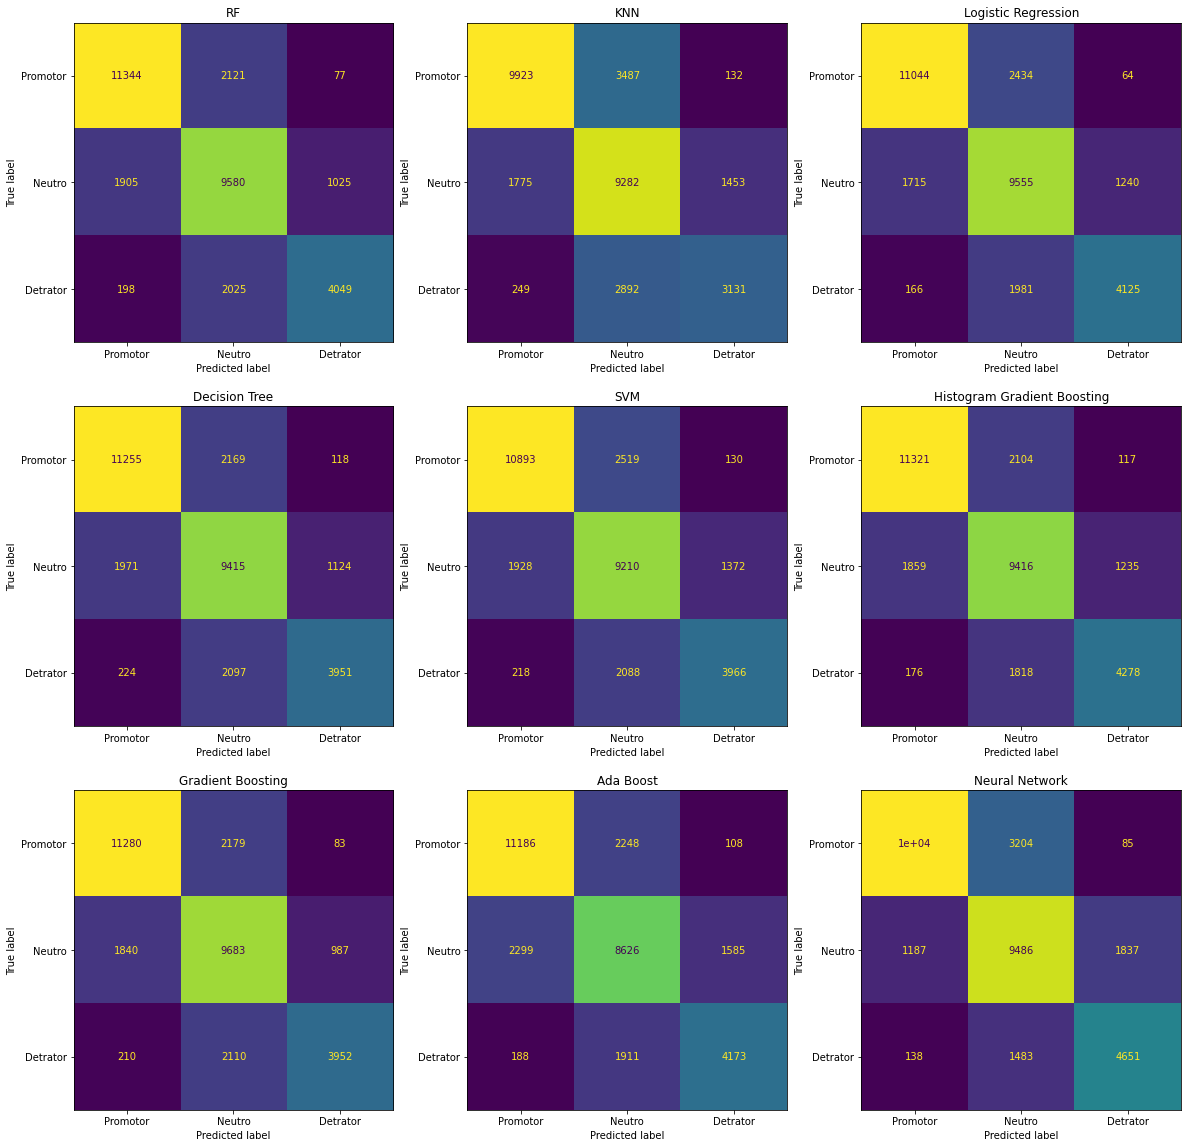

In [46]:
PlotConfusionMatrixs(confusion_dict, ["Promotor", "Neutro", "Detrator"], Models_Loaded_GridSearch)
